# 5장. 차원 축소를 사용한 데이터 압축

특성 추출 - 데이터 압축하기:  
* 주성분 분석 - 비지도 데이터 압축
* 선형 판별 분석 - 지도 방식 차원 축소 기법
* 커널 PCA - 비선형 차원 축소

## 5.1 주성분 분석을 통한 비지도 차원 축소

새로운 특성 공간으로 데이터를 변환하거나 투영  
대부분의 관련 있는 정보를 유지하면서 데이터를 압축  
특히 규제가 없는 모델로 작업할 때 차원의 저주 문제를 감소시켜 예측 성능을 향상

### 5.1.1 주성분 분석의 주요 단계

*USAGE)* exploratory data analysis, 주식 거래 시장의 잡음 제거, 게놈 데이터나 유전자 발현 분석 등에 이용  
PCA는 고차원 데이터에서 분산이 가장 큰 방향을 찾고 좀 더 작거나 같은 수의 차원을 갖는 새로운 부분 공간으로 이를 투영  
차원을 축소하기 위해 $d\times k$ 차원의 변환 행렬 $\mathbf{W}$ 를 만듦  
원본 $d$ 차원 데이터를 새로운 $k$ 차원의 부분 공간으로 변환하여 만들어진 첫번재 주성분이 가장 큰 분산을 가짐  

이를 정리하면:  
1) $d$ 차원 데이터셋을 *표준화 전처리*
2) *공분산 행렬*을 만듦
3) 공분산 행렬을 *고유 벡터*와 *고유값*으로 분해
4) 고유값을 내림차순으로 정렬하고 그에 해당하는 고유 벡터의 순위를 매김
5) 고유값이 가장 큰 $k$ 개의 고유 벡터를 선택
6) 최상위 $k$ 개의 고유 벡터로 *투영 행렬* $\mathbf{W}$ 를 만듦
7) 투영 행렬을 이용하여 새로운 차원의 특성 부분 공간으로 변환  

### 5.1.2 주성분 추출 단계

1번 과정부터 4번 과정까지

In [1]:
# Wine 데이터셋 로드
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

In [2]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)

# 특성을 표준화 전처리
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

두 특성 $x_j$와 $x_k$ 사이의 공분산  
$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^n (x_j^{(i)}-\mu_j)(x_k^{(i)}-\mu_k)$$

In [3]:
# 공분산 행렬 구하기 -> 고유 벡터와 고유값 쌍 구하기
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n고유값 \n%s' % eigen_vals)


고유값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### 5.1.3 총 분산과 설명된 분산

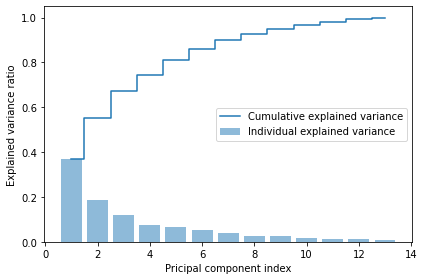

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
           sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Pricipal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 5.1.4 특성 변환

5번 과정에서 7번 마지막까지  

* 고유값이 가장 큰 고유 벡터를 선택
* 최상위 고유 벡터로 투영 행렬을 만듦
* 투영 행렬을 사용해서 새로운 차원의 특성 부분 공간으로 변환


In [5]:
# (고유값, 고유벡터) 튜플의 리스트를 만듦
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
# 내림차순으로 튜플을 정렬
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [6]:
# 고유벡터로부터 투영행렬 만들기
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [7]:
# 샘플을 PCA 부분 공간으로 투영
X_train_pca = X_train_std.dot(w)

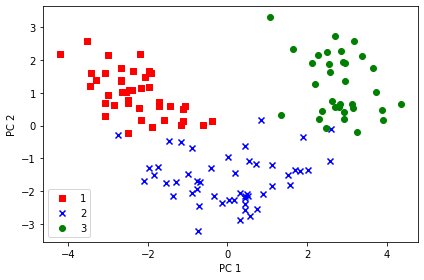

In [8]:
# 산점도로 시각화
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 5.1.5 사이킷런의 주성분 분석

`PCA` 클래스 이용하여 구현

/Users/sunghyouk/github/study_room/python_ML/plot_decision_regions.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


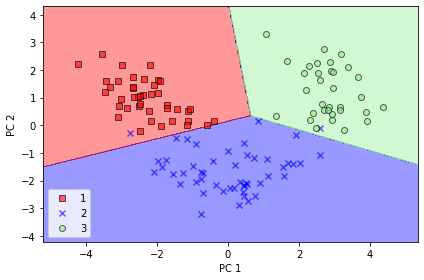

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import plot_decision_regions as pltreg

# PCA 변환기와 로지스틱 회기 추정기를 초기화
pca = PCA(n_components=2)
lr = LogisticRegression(random_state=1)

# 차원 축소
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# 축소된 데이터셋으로 로지스틱 회귀 모델 훈련
lr.fit(X_train_pca, y_train)
pltreg.plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

/Users/sunghyouk/github/study_room/python_ML/plot_decision_regions.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


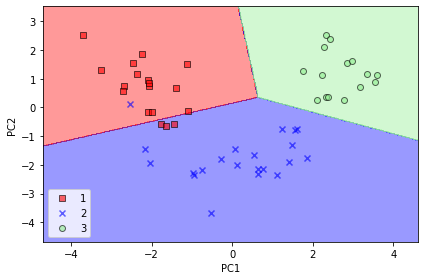

In [14]:
pltreg.plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [11]:
# 전체 주성분의 설명된 분산 비율을 보고 싶다면
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [15]:
pca = PCA(n_components=0.95)
pca.fit(X_train_std)
print('주성분 개수: ', pca.n_components_)
print('설명된 분산 비율: ', np.sum(pca.explained_variance_ratio_))

주성분 개수:  10
설명된 분산 비율:  0.9662714406558743


In [16]:
pca = PCA(n_components='mle')
pca.fit(X_train_std)
print('주성분 개수: ', pca.n_components_)
print('설명된 분산 비율: ', np.sum(pca.explained_variance_ratio_))

주성분 개수:  9
설명된 분산 비율:  0.9499753029186233


In [18]:
# 데이터 일부를 사용해 반복적으로 훈련
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=9)
for batch in range(len(X_train_std)//25 + 1):
    X_batch = X_train_std[batch*25:(batch+1)*25]
    ipca.partial_fit(X_batch)
print('주성분 개수: ', ipca.n_components_)
print('설명된 분산 비율: ', np.sum(ipca.explained_variance_ratio_))

주성분 개수:  9
설명된 분산 비율:  0.9478392700446663


## 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축

일반적인 개념은 PCA와 유사  
LDA 목표는 클래스를 최적으로 구분할 수 있는 특성 부분 공간을 찾는 것

### 5.2.1 주성분 분석 vs 선형 판별 분석

선형 판별 분석은 지도 학습 알고리즘  
데이터가 정규 분포라고 가정  
클래스가 동일한 공분산 행렬을 가지고 훈련 샘플은 서로 통계적으로 독립적이라고 가정

### 5.2.2 선형 판별 분석의 내부 동작 방식

1. $d$ 차원의 데이터셋을 표준화 전처리
2. 각 클래스에 대해 $d$ 차원의 평균 벡터를 계산
3. 클래스 간의 산포 행렬 ($\mathbf{S}_B$), 클래스 내 산포 행렬 ($\mathbf{S}_W$)을 구성
4. $\mathbf{S}_W^{-1}\mathbf{S}_B$ 행렬의 고유 벡터와 고유값 계산
5. 고유값을 내림차순으로 정렬하여 순서를 메김
6. 고유값이 가장 큰 $k$개의 고유 벡터를 선택하여 변환 행렬 $\mathbf{W}$를 구성
7. 샘플을 새로운 특성 부분 공간으로 투영

클레스 레이블 별로 데이터를 나누어 평균을 구함

### 5.2.3 산포 행렬 계산

평균 벡터 ($\mathbf{m}_i$) = 클래스 $i$의 샘플에 대한 특성의 평균값 $\mu_m$을 저장

In [19]:
# 평균 벡터 계산
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(
        X_train_std[y_train==label], axis=0
    ))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [20]:
# 클래스 내 산포 행렬 계산
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('클래스 내의 산포 행렬: %s x %s' % (
    S_W.shape[0], S_W.shape[1]
))

클래스 내의 산포 행렬: 13 x 13


In [21]:
# 산포 행렬 계산 시 클래스 레이블이 균등하게 분포되어 있다고 가정
print('클래스 레이블 분포: %s'
      % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


균등하지 않으므로 스케일을 조정, `공분산 행렬`을 사용